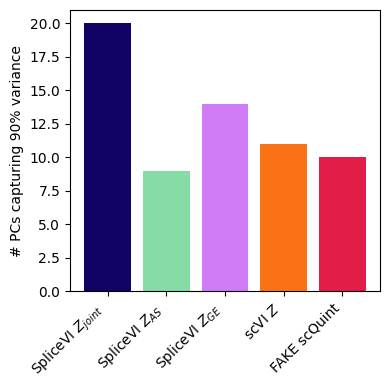

In [14]:
# --- FIGURE: # of PCs capturing 90% variance ---
# USER INPUT: replace values below with your real numbers from W&B
pc90_values = {
    "SpliceVI $Z_{joint}$": 20,
    "SpliceVI $Z_{AS}$": 9,
    "SpliceVI $Z_{GE}$": 14,
    "scVI $Z$": 11,
    "FAKE scQuint": 10,
}

colors = ["#110265", "#86DCA5", "#D07CF7", "#F97316", "#E11D48"]

# ---- plotting (matplotlib only) ----
import matplotlib.pyplot as plt

labels = list(pc90_values.keys())
vals = [pc90_values[k] for k in labels]

plt.figure(figsize=(4, 4))
plt.bar(range(len(labels)), vals, color=colors)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("# PCs capturing 90% variance")
plt.tight_layout()
plt.savefig("fig_pc90.png", dpi=300, bbox_inches="tight")
plt.show()


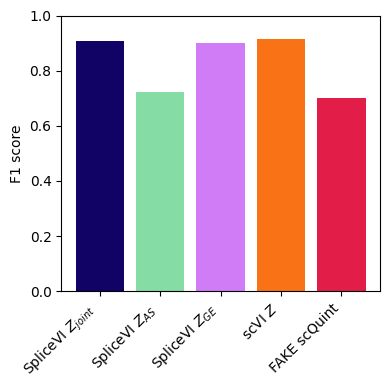

In [20]:
# --- FIGURE: F1 score of cell-type classification ---
# USER INPUT: replace values below with your real numbers from W&B
f1_values = {
    "SpliceVI $Z_{joint}$": 0.9088899172826298,
    "SpliceVI $Z_{AS}$": 0.7235397932961396,
    "SpliceVI $Z_{GE}$": 0.8990515236501309,
    "scVI $Z$": 0.9151672713842393,
    "FAKE scQuint": 0.70,
}
colors = ["#110265", "#86DCA5", "#D07CF7", "#F97316", "#E11D48"]

# ---- plotting (matplotlib only) ----
import matplotlib.pyplot as plt

labels = list(f1_values.keys())
vals = [f1_values[k] for k in labels]

plt.figure(figsize=(4, 4))
plt.bar(range(len(labels)), vals, color = colors)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylim(0, 1.0)
plt.ylabel("F1 score")
plt.tight_layout()
plt.savefig("fig_f1.png", dpi=300, bbox_inches="tight")
plt.show()


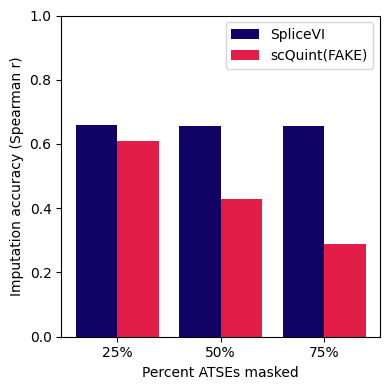

In [70]:
# --- FIGURE: Imputation accuracy vs % masked ---
# USER INPUT: replace with your real values from W&B
# Keys are mask percentages (x-axis). Values are dicts of model -> accuracy (e.g., Spearman r).
impute_values = {
    "25%": {"SpliceVI": 0.6586, "scQuint(FAKE)": 0.61},
    "50%": {"SpliceVI": 0.6568, "scQuint(FAKE)": 0.43},
    "75%": {"SpliceVI": 0.65719, "scQuint(FAKE)": 0.29},
}
colors = ["#110265", "#E11D48"]
# ---- plotting (matplotlib only) ----
import numpy as np
import matplotlib.pyplot as plt

masks = list(impute_values.keys())
models ={m for d in impute_values.values() for m in d.keys()}
x = np.arange(len(masks))
width = 0.8 / max(1, len(models))  # bar width

plt.figure(figsize=(4, 4))
for i, model in enumerate(models):
    y = [impute_values[p].get(model, np.nan) for p in masks]
    plt.bar(x + i * width - (len(models) - 1) * width / 2, y, width=width, label=model, color = colors[i])

plt.xticks(x, masks)
plt.ylim(0, 1.0)
plt.xlabel("Percent ATSEs masked")
plt.ylabel("Imputation accuracy (Spearman r)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_impute.png", dpi=300, bbox_inches="tight")
plt.show()


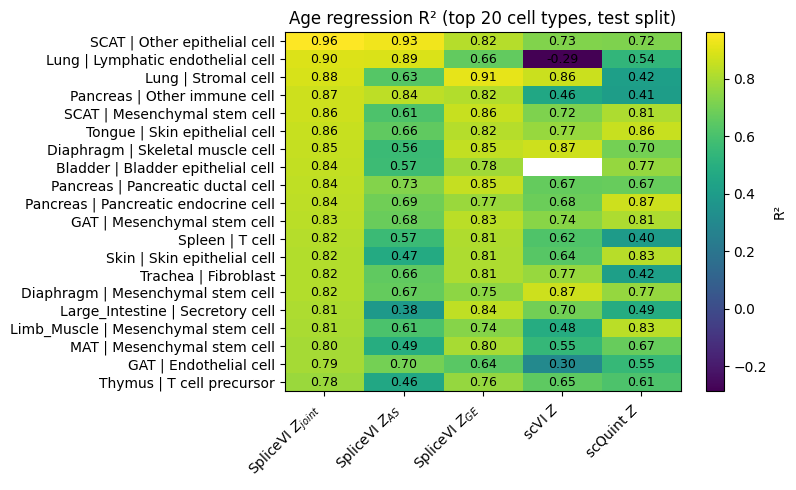

In [59]:
# --- FIGURE: Age regression R² heatmap (top-N cell types, test split) ---
# USER INPUT:
splicevi_csv = "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251026_163736/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=sum/figures/age_r2_by_tissue_celltype_train_test.csv"  # test metrics for SpliceVI
scvi_csv     = "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251024_143019.csv"      # test metrics for scVI
TOP_N = 20                                  # number of cell types to display

# ---- load, filter, and assemble table ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_age_r2(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","space","pair","r2"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    # Standardize string cases
    df["dataset"] = df["dataset"].astype(str).str.lower()
    df["space"]   = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    return df

# Load
sv = load_age_r2(splicevi_csv)
sc = load_age_r2(scvi_csv)

# Keep only TEST rows
sv = sv[sv["dataset"] == "test"].copy()
sc = sc[sc["dataset"] == "test"].copy()

# Extract SpliceVI three spaces
# Expect values among {"joint","splicing","expression"} for SpliceVI
want_spaces = ["joint","splicing","expression"]
sv = sv[sv["space"].isin(want_spaces)].copy()

# Pivot SpliceVI to wide: rows=pair, cols=SpliceVI spaces
sv_wide = sv.pivot_table(index="pair", columns="space", values="r2", aggfunc="mean")

# Rank cell types by SpliceVI joint R² (fallback: by row mean if joint missing)
if "joint" in sv_wide.columns:
    ranking = sv_wide["joint"].fillna(-1.0)
else:
    ranking = sv_wide.mean(axis=1).fillna(-1.0)

top_cells = ranking.sort_values(ascending=False).head(TOP_N).index.tolist()
sv_top = sv_wide.loc[top_cells]

# Get scVI (single Z)
# Some CSVs might label space simply as "z" or blank; if not present, take max per pair
if "space" in sc.columns:
    # Try to find a reasonable scVI space name; otherwise, collapse by mean
    candidate_scvi = sc[sc["space"].isin(["z","latent","na",""])] if "z" in sc["space"].unique() else sc
else:
    candidate_scvi = sc
scvi_series = candidate_scvi.groupby("pair")["r2"].mean()

# Create scQuint placeholder (random; replace when ready)
rng = np.random.default_rng(0)
scquint_series = pd.Series(
    data=rng.uniform(0.4, 0.9, size=len(top_cells)),
    index=top_cells,
    name="scQuint Z",
)

# Align to top cell types
scvi_top = scvi_series.reindex(top_cells)
scquint_top = scquint_series.reindex(top_cells)

# Assemble final matrix with requested columns/order
heat_df = pd.DataFrame({
    "SpliceVI $Z_{joint}$": sv_top.get("joint"),
    "SpliceVI $Z_{AS}$": sv_top.get("splicing"),
    "SpliceVI $Z_{GE}$": sv_top.get("expression"),
    "scVI $Z$": scvi_top,
    "scQuint $Z$": scquint_top,
}, index=top_cells)

# Optional: round for cleaner annotations
heat_annot = heat_df.round(3)

# ---- plot (matplotlib) ----
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(heat_df.values, aspect="auto")
ax.set_xticks(range(heat_df.shape[1]))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
ax.set_yticks(range(heat_df.shape[0]))
ax.set_yticklabels(heat_df.index)
ax.set_title(f"Age regression R² (top {TOP_N} cell types, test split)")
# annotate cells
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        val = heat_annot.iloc[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="R²")
plt.tight_layout()
plt.savefig("fig_age_r2_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


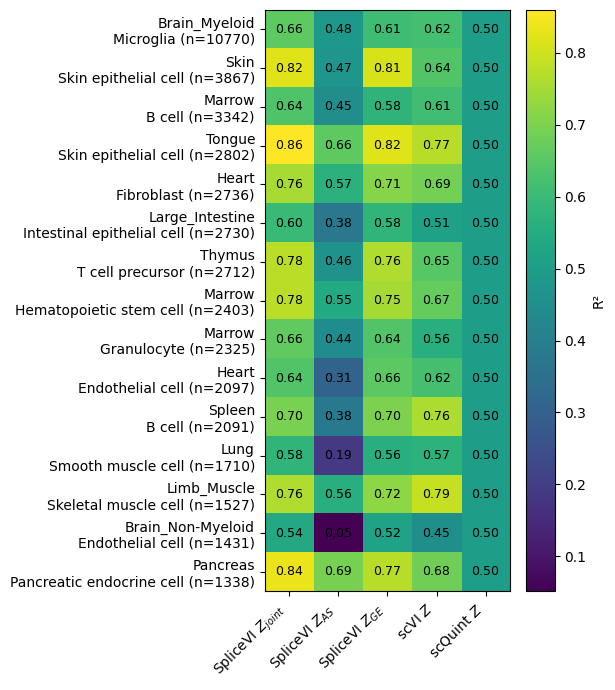

In [63]:
# --- FIGURE: Age regression R² heatmap (Top-N most populated cell types by `n`, test split) ---
# USER INPUT:
splicevi_csv = "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251026_163736/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=sum/figures/age_r2_by_tissue_celltype_train_test.csv"  # must contain: dataset, space, pair, r2, n
scvi_csv     = "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251024_143019.csv"      # must contain: dataset, (space optional), pair, r2, n
TOP_N = 15

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_age(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","pair","r2","n"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    # normalize
    df["dataset"]   = df["dataset"].astype(str).str.lower()
    if "space" not in df.columns:
        df["space"] = ""  # allow scVI files without an explicit space label
    else:
        df["space"] = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    return df

sv = load_age(splicevi_csv)
sc = load_age(scvi_csv)

# keep only TEST rows
sv = sv[sv["dataset"] == "test"].copy()
sc = sc[sc["dataset"] == "test"].copy()

# ---- Select top-N most populated cell types by total n (SpliceVI test) ----
# If you prefer to aggregate counts across spaces, we sum n over all spaces per pair.
ct_counts = sv.groupby("pair", as_index=False)["n"].sum().sort_values("n", ascending=False)
top_cells = ct_counts["pair"].head(TOP_N).tolist()

# ---- Build R² matrix for required columns/spaces ----
# SpliceVI spaces we want
want_spaces = ["joint","splicing","expression"]
sv_sel = sv[sv["space"].isin(want_spaces)].copy()
sv_wide = sv_sel.pivot_table(index="pair", columns="space", values="r2", aggfunc="mean")

# scVI single latent (aggregate across any 'space' labels if present)
scvi_series = sc.groupby("pair")["r2"].mean()

# scQuint placeholder for now (replace when you have real CSV)
rng = np.random.default_rng(0)
scquint_series = pd.Series(
    data=rng.uniform(0.5, 0.5, size=len(top_cells)),
    index=top_cells,
    name="scQuint Z",
)

# Align to top cells
sv_top = sv_wide.reindex(index=top_cells)
scvi_top = scvi_series.reindex(top_cells)
scquint_top = scquint_series.reindex(top_cells)

# Final matrix in desired column order
heat_df = pd.DataFrame({
    "SpliceVI $Z_{joint}$":     sv_top.get("joint"),
    "SpliceVI $Z_{AS}$":  sv_top.get("splicing"),
    "SpliceVI $Z_{GE}$":      sv_top.get("expression"),
    "scVI $Z$":               scvi_top,
    "scQuint $Z$":            scquint_top,
}, index=top_cells)

# Optional: append counts to ytick labels
counts_map = dict(zip(ct_counts["pair"], ct_counts["n"]))
yticks = [f"{ct} (n={int(counts_map.get(ct, 0))})" for ct in heat_df.index]

# ---- Plot (matplotlib only) ----
fig, ax = plt.subplots(figsize=(6, 7))
im = ax.imshow(heat_df.values, aspect="auto")
ax.set_xticks(range(heat_df.shape[1]))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
yticks_wrapped = [s.replace(" | ", "\n") for s in yticks]
ax.set_yticks(range(len(yticks_wrapped)))
ax.set_yticklabels(yticks_wrapped)

# ax.set_title(f"Age regression $R^2$ (Top {len(top_cells)} most populated cell types, test)")
# annotate cells
ann = heat_df.round(3)
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        v = ann.iloc[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="R²")
plt.tight_layout()
plt.savefig("fig_age_r2_heatmap_topN_by_n.png", dpi=300, bbox_inches="tight")
plt.show()


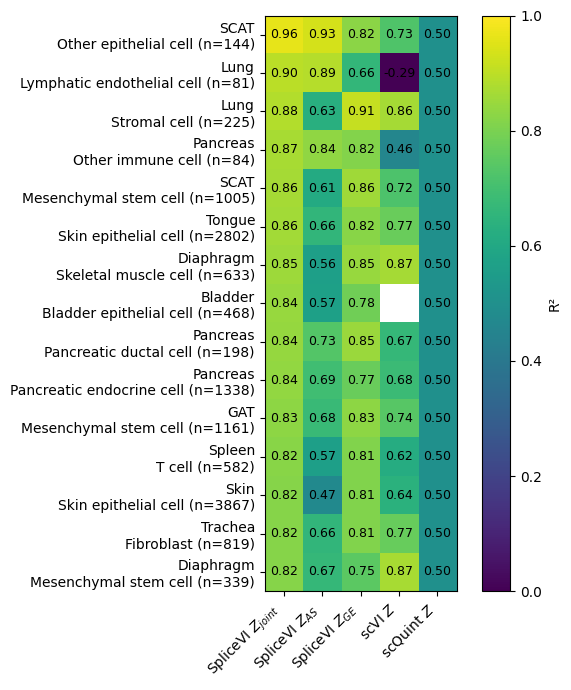

In [69]:
# --- FIGURE: Age regression R² heatmap (Top-N cell types, test split) ---
# USER INPUT:
splicevi_csv = "/gpfs/commons/home/svaidyanathan/splice_vi_partial_vae_sweep/batch_20251026_163736/mouse_trainandtest_REAL_cd=32_mn=50000_ld=25_lr=1e-5_0_scatter_PartialEncoderEDDI_pool=sum/figures/age_r2_by_tissue_celltype_train_test.csv"
scvi_csv     = "/gpfs/commons/home/svaidyanathan/scvi_age/model/age_r2_by_tissue_celltype_train_test_target_ages_3_18_24_scvi_SCVI_age_only_20251024_143019.csv"
TOP_N = 15
ORDER_BY = "r2"      # options: "n" for most populated, "r2" for highest SpliceVI joint R^2
ASCENDING = False   # usually False for both modes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_age(csv_path):
    df = pd.read_csv(csv_path)
    required = {"dataset","pair","r2","n"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in {csv_path}: {missing}")
    df["dataset"]   = df["dataset"].astype(str).str.lower()
    if "space" not in df.columns:
        df["space"] = ""
    else:
        df["space"] = df["space"].astype(str).str.lower()
    df["pair"] = df["pair"].astype(str)
    df["n"] = pd.to_numeric(df["n"], errors="coerce")
    df["r2"] = pd.to_numeric(df["r2"], errors="coerce")
    return df

sv = load_age(splicevi_csv)
sc = load_age(scvi_csv)

# keep only TEST rows
sv = sv[sv["dataset"] == "test"].copy()
sc = sc[sc["dataset"] == "test"].copy()

# SpliceVI spaces we want
want_spaces = ["joint","splicing","expression"]
sv_sel = sv[sv["space"].isin(want_spaces)].copy()

# Wide table for SpliceVI (rows=pairs, cols=spaces)
sv_wide = sv_sel.pivot_table(index="pair", columns="space", values="r2", aggfunc="mean")

# Counts per pair (sum over spaces)
ct_counts = sv_sel.groupby("pair", as_index=False)["n"].sum().sort_values("n", ascending=False)

# ---- Top-N selection toggle ----
if ORDER_BY.lower() == "n":
    order_series = ct_counts.set_index("pair")["n"]
elif ORDER_BY.lower() == "r2":
    if "joint" in sv_wide.columns:
        order_series = sv_wide["joint"].fillna(-1.0)
    else:
        # fallback: average across spaces
        order_series = sv_wide.mean(axis=1).fillna(-1.0)
else:
    raise ValueError("ORDER_BY must be 'n' or 'r2'")

# sort and pick top-N
order_series = order_series.sort_values(ascending=ASCENDING)
top_pairs = order_series.index[:TOP_N].tolist()

# slice matrices to top-N
sv_top = sv_wide.reindex(index=top_pairs)

# scVI single latent (aggregate if multiple space labels exist)
scvi_series = sc.groupby("pair")["r2"].mean().reindex(top_pairs)

# scQuint placeholder (replace when you have real CSV)
rng = np.random.default_rng(0)
scquint_series = pd.Series(
    data=rng.uniform(0.5, 0.5, size=len(top_pairs)),
    index=top_pairs,
    name="scQuint Z",
)

# Final matrix in desired column order
heat_df = pd.DataFrame({
    "SpliceVI $Z_{joint}$":    sv_top.get("joint"),
    "SpliceVI $Z_{AS}$":       sv_top.get("splicing"),
    "SpliceVI $Z_{GE}$":       sv_top.get("expression"),
    "scVI $Z$":                scvi_series,
    "scQuint $Z$":             scquint_series,
}, index=top_pairs)

# ytick labels with counts
counts_map = dict(zip(ct_counts["pair"], ct_counts["n"]))
yticks = [f"{p} (n={int(counts_map.get(p, 0))})" for p in heat_df.index]
yticks_wrapped = [s.replace(" | ", "\n") for s in yticks]

# ---- Plot ----
fig, ax = plt.subplots(figsize=(6, 7))
im = ax.imshow(heat_df.values, vmin=0, vmax=1)
ax.set_xticks(range(heat_df.shape[1]))
ax.set_xticklabels(heat_df.columns, rotation=45, ha="right")
ax.set_yticks(range(len(yticks_wrapped)))
ax.set_yticklabels(yticks_wrapped)
# annotate cells
ann = heat_df.round(3)
for i in range(heat_df.shape[0]):
    for j in range(heat_df.shape[1]):
        v = ann.iloc[i, j]
        if pd.notna(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, label="R²")
plt.tight_layout()
plt.savefig(f"fig_age_r2_heatmap_top{TOP_N}_orderby_{ORDER_BY}.png", dpi=300, bbox_inches="tight")
plt.show()
